In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
# Load the Excel file
df = pd.read_excel('C:/Users/Galindo/Desktop/Energy_consumption.xls', header=14)

# Remove the 'Unnamed: 3' column
df.drop(columns=['Unnamed: 3'], inplace=True)
excel = df.copy()
excel_1 = df.copy()
# Check the column names
print(df.columns)

# Check for null values
print(df.isnull().sum())

print(df)


Index(['Date', 'Hour', 'Q-Enginyeria-Total [kWh]'], dtype='object')
Date                        0
Hour                        0
Q-Enginyeria-Total [kWh]    0
dtype: int64
                     Date                Hour  Q-Enginyeria-Total [kWh]
0     2018-01-01 00:00:00 2018-01-01 00:00:00                177.000000
1     2018-01-01 01:00:00 2018-01-01 01:00:00                177.440000
2     2018-01-01 02:00:00 2018-01-01 02:00:00                176.570000
3     2018-01-01 03:00:00 2018-01-01 03:00:00                174.980000
4     2018-01-01 04:00:00 2018-01-01 04:00:00                174.510000
...                   ...                 ...                       ...
53624 2024-02-13 08:00:00 2024-02-13 08:00:00                363.222567
53625 2024-02-13 09:00:00 2024-02-13 09:00:00                388.690476
53626 2024-02-13 10:00:00 2024-02-13 10:00:00                417.800000
53627 2024-02-13 11:00:00 2024-02-13 11:00:00                440.495455
53628 2024-02-13 12:00:00 2024-02-13 

VISUALIZATION BASED ON MEANS

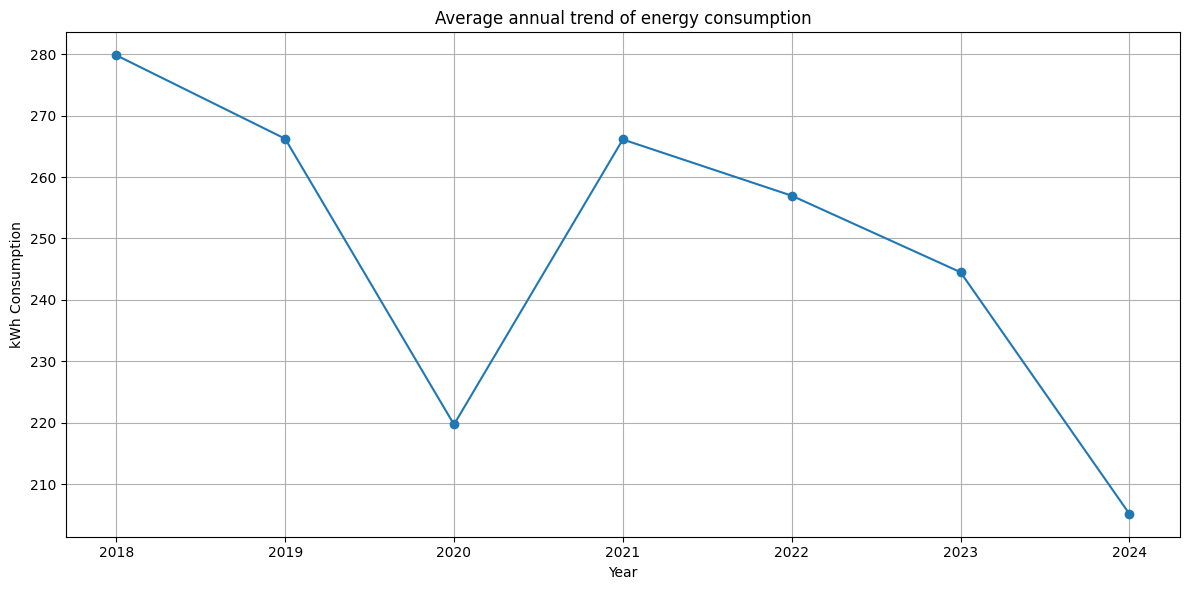

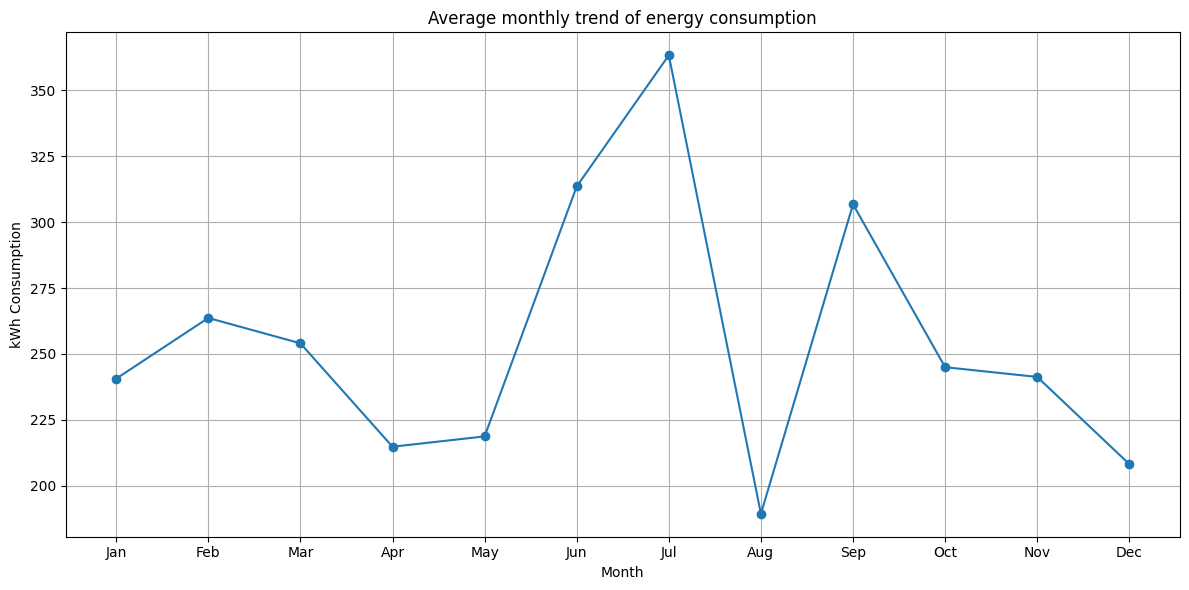

In [5]:
# Calculate the average kWh consumption per year and per month
yearly_consumption = df.groupby(df['Date'].dt.year)['Q-Enginyeria-Total [kWh]'].mean()
monthly_consumption = df.groupby(df['Date'].dt.month)['Q-Enginyeria-Total [kWh]'].mean()

# Visualization of average annual trend
plt.figure(figsize=(12, 6))
yearly_consumption.plot(marker='o', linestyle='-')
plt.title('Average annual trend of energy consumption')
plt.xlabel('Year')
plt.ylabel('kWh Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization of average monthly trend
plt.figure(figsize=(12, 6))
monthly_consumption.plot(marker='o', linestyle='-')
plt.title('Average monthly trend of energy consumption')
plt.xlabel('Month')
plt.ylabel('kWh Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()


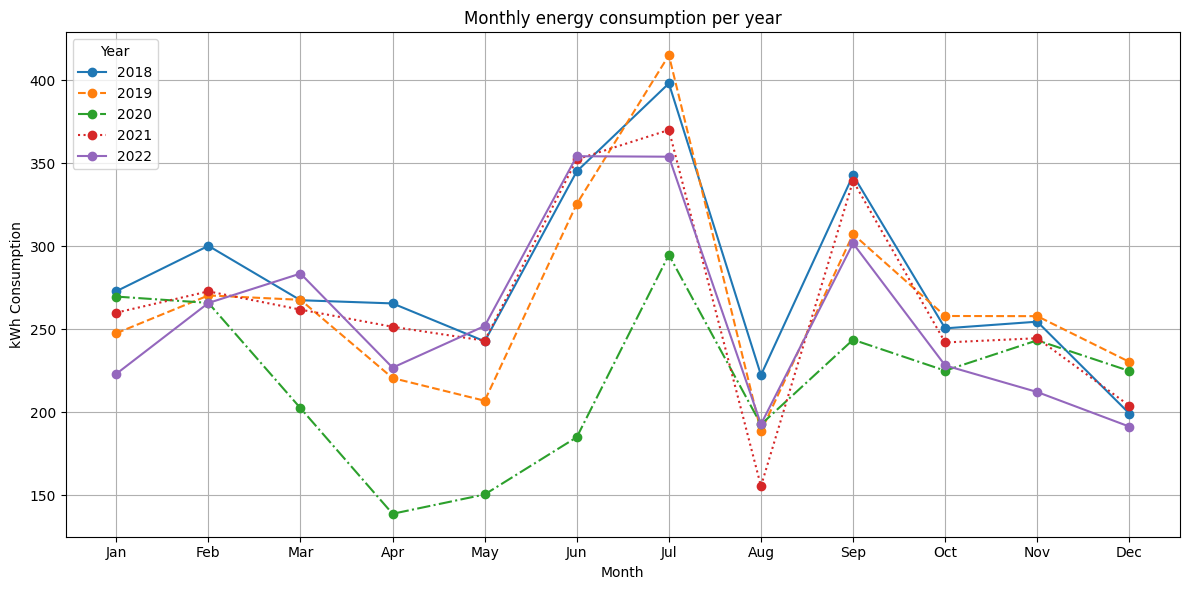

In [6]:
# Colors for each line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Line style and markers
line_styles = ['-', '--', '-.', ':', '-']

# Calculate the average kWh consumption per month and per year
yearly_monthly_consumption = df.groupby([df['Date'].dt.year, df['Date'].dt.month])['Q-Enginyeria-Total [kWh]'].mean().unstack()

# Transpose the data to have years as columns and months as rows
yearly_monthly_consumption = yearly_monthly_consumption.T

# Visualization of the comparison of monthly energy consumption between different years
plt.figure(figsize=(12, 6))
for i, (year, color, line_style) in enumerate(zip(yearly_monthly_consumption.columns, colors, line_styles)):
    plt.plot(yearly_monthly_consumption.index, yearly_monthly_consumption[year], marker='o', linestyle=line_style, color=color, label=year)

plt.title('Monthly energy consumption per year')
plt.xlabel('Month')
plt.ylabel('kWh Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()


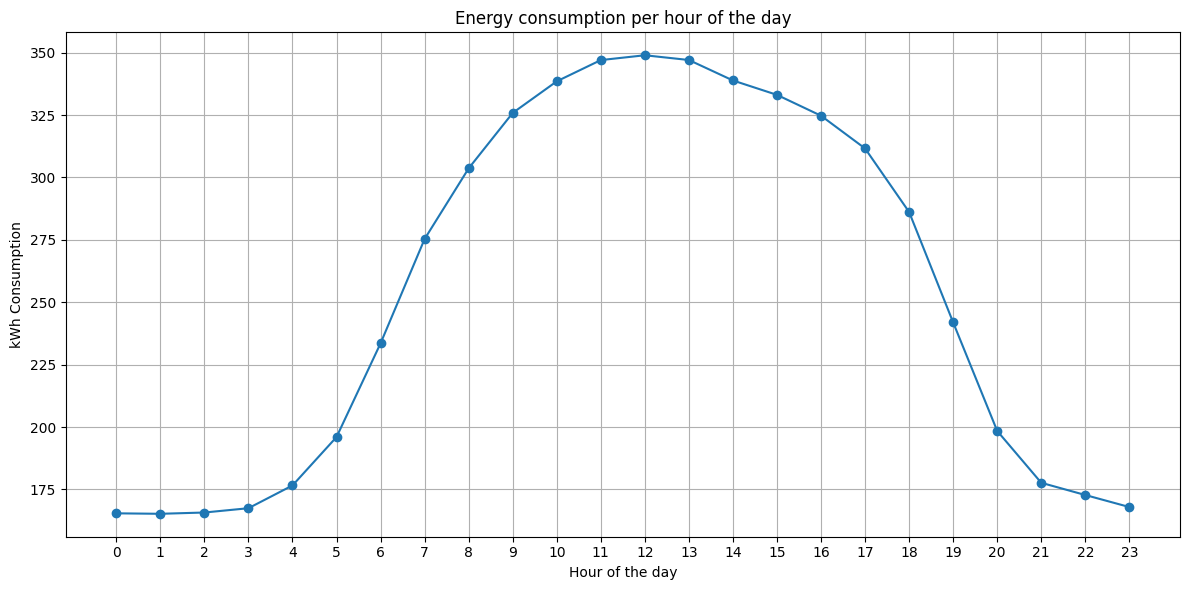

In [7]:
# Calculate the average kWh consumption per hour of the day
hourly_consumption = df.groupby(df['Date'].dt.hour)['Q-Enginyeria-Total [kWh]'].mean()

# Visualization of energy consumption per hour of the day
plt.figure(figsize=(12, 6))
hourly_consumption.plot(marker='o', linestyle='-')
plt.title('Energy consumption per hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('kWh Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


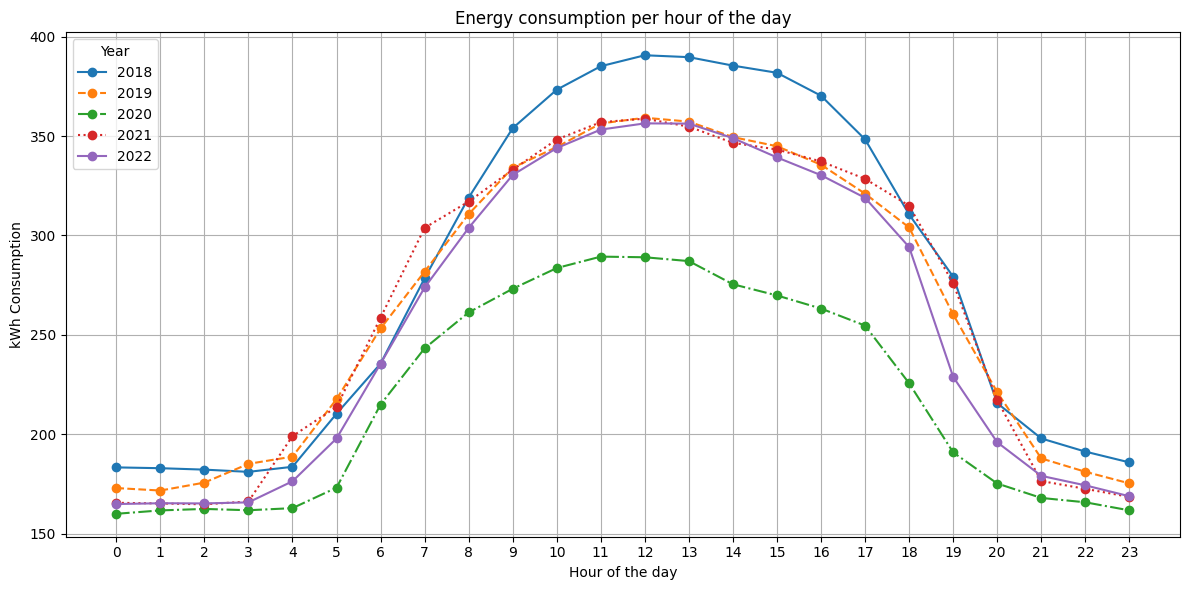

In [8]:
# Calculate the average kWh consumption per hour of the day
hourly_consumption = df.groupby([df['Date'].dt.year, df['Date'].dt.hour])['Q-Enginyeria-Total [kWh]'].mean().unstack()

# Transpose the data to have years as columns and hours as rows
hourly_consumption = hourly_consumption.T

# Colors for each line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Line style and markers
line_styles = ['-', '--', '-.', ':', '-']

# Visualization of energy consumption per hour of the day
plt.figure(figsize=(12, 6))
for i, (year, color, line_style) in enumerate(zip(hourly_consumption.columns, colors, line_styles)):
    plt.plot(hourly_consumption.index, hourly_consumption[year], marker='o', linestyle=line_style, color=color, label=year)

plt.title('Energy consumption per hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('kWh Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()


HOURLY FORECASTING

In [12]:

# Assuming 'Date' and 'Hour' are separate or not properly formatted as datetime
df['Date'] = pd.to_datetime(df['Date'])  # Converts column to datetime

# Display the first few rows of the dataframe
df.head()


,Date,Hour,Q-Enginyeria-Total [kWh]
0,2018-01-01 00:00:00,2018-01-01 00:00:00,177.00
1,2018-01-01 01:00:00,2018-01-01 01:00:00,177.44
2,2018-01-01 02:00:00,2018-01-01 02:00:00,176.57
3,2018-01-01 03:00:00,2018-01-01 03:00:00,174.98
4,2018-01-01 04:00:00,2018-01-01 04:00:00,174.51


In [13]:
# Set datetime as the index of the dataframe
df.index = pd.to_datetime(df['Date'])
df.drop(['Date', 'Hour'], axis=1, inplace=True)  # Drop redundant columns if necessary

# Check the head of the dataframe to confirm changes
print(df.head())


                     Q-Enginyeria-Total [kWh]
Date                                         
2018-01-01 00:00:00                    177.00
2018-01-01 01:00:00                    177.44
2018-01-01 02:00:00                    176.57
2018-01-01 03:00:00                    174.98
2018-01-01 04:00:00                    174.51


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Optionally convert back to dataframe for easier handling
data_scaled = pd.DataFrame(data_scaled, index=df.index, columns=['Energy'])


In [15]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # use the last 24 hours to predict the next hour
X, Y = create_dataset(data_scaled.values, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [63]:
# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]


In [64]:
# Define the model
model = Sequential()

# Adding the LSTM layer:
# - units: the dimensionality of the output space
# - return_sequences: True if another LSTM layer follows
# - input_shape: shape of the input. Only necessary for the first layer.
model.add(LSTM(units=50, return_sequences=True, input_shape=(None, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer, 1 unit for output
model.add(Activation('relu'))  # Ensure the output is non-negative

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Galindo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8)

Epoch 1/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 101s 22ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 2/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 11/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1

In [66]:
# Example of making predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transformation for original scale values
trainPredict = scaler.inverse_transform(trainPredict)
Y_train_inv = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train_inv[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(Y_test_inv[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Train Score: 25.77 RMSE
Test Score: 27.77 RMSE


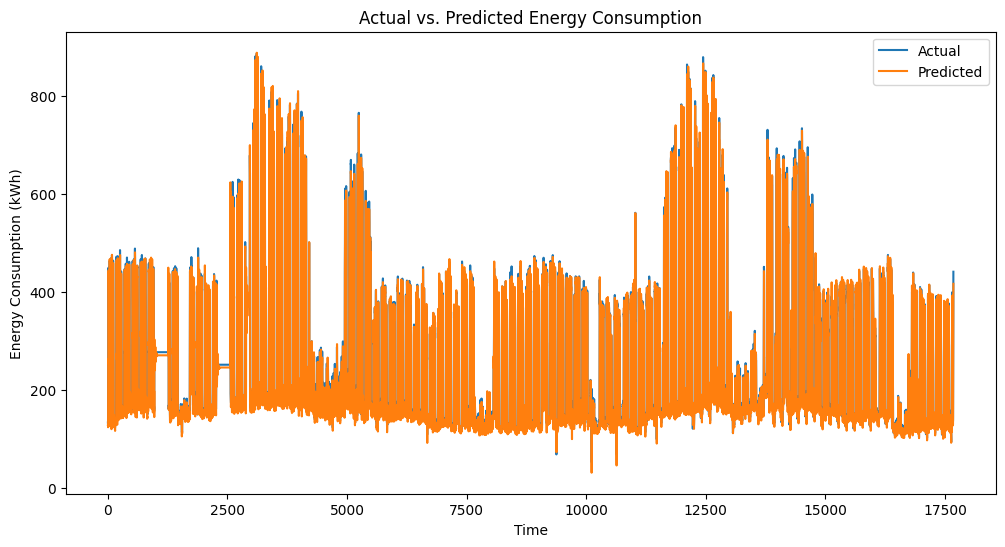

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test_inv[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.show()


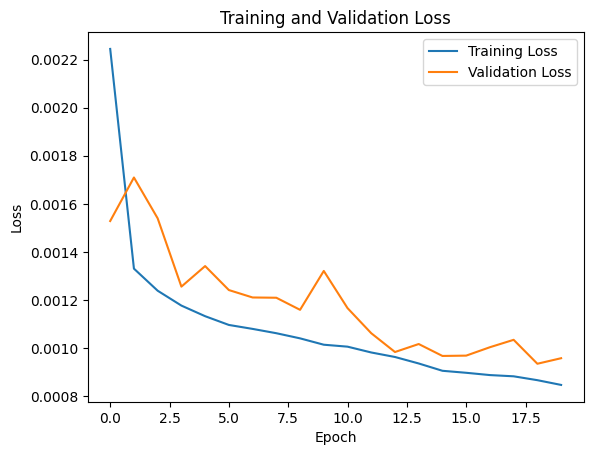

In [68]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


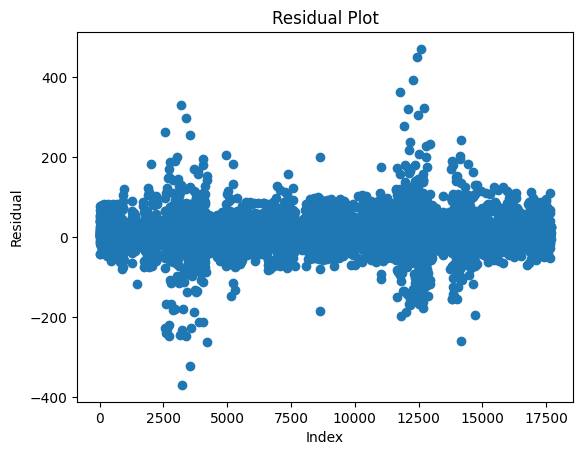

In [69]:
# Plotting the residuals (the differences between actual and predicted values) can help identify patterns or biases in your model's predictions.
residuals = Y_test_inv[0] - testPredict[:,0]
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


In [70]:
# Generate timestamps for the next 7 days
future_dates = pd.date_range(start='2024-02-13', periods=24*7, freq='H')

# Reshape the data for the next 7 days
future_data = []

# Initialize the last known data as the initial input for the first prediction
last_known_data = data_scaled.iloc[-look_back:].values.reshape((1, look_back, 1))

for i, future_date in enumerate(future_dates):
    # Make predictions for the next hour
    predicted_value = model.predict(last_known_data)
    
    # Inverse transform the predicted value to the original scale
    predicted_value_original_scale = scaler.inverse_transform(predicted_value)
    
    # Append the predicted value to the future_data list
    future_data.append(predicted_value_original_scale[0][0])
    
    # Update last_known_data by removing the oldest value and appending the predicted value
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# Print predicted values for each future date
for i, timestamp in enumerate(future_dates):
    print("Predicted energy consumption for", timestamp, ":", future_data[i])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\Galindo\AppData\Local\Temp\ipykernel_23928\3328449561.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2024-02-13', periods=24*7, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

PREDICTIONS WITH DAILY AVERAGE

In [9]:
# Group the data by date and calculate the average energy consumption for each day
df_daily_avg = excel.groupby(excel['Date'].dt.date)['Q-Enginyeria-Total [kWh]'].mean().reset_index()
df_daily_avg.head()

,Date,Q-Enginyeria-Total [kWh]
0,2018-01-01,190.587500
1,2018-01-02,197.193750
2,2018-01-03,208.457500
3,2018-01-04,208.867917
4,2018-01-05,207.792500


In [16]:
# Reshape the data for scaling
daily_data_scaled = scaler.fit_transform(df_daily_avg[['Q-Enginyeria-Total [kWh]']])

# Optionally convert back to DataFrame for easier handling
daily_data_scaled = pd.DataFrame(daily_data_scaled, index=df_daily_avg.index, columns=['Q-Enginyeria-Total [kWh]'])



In [17]:
look_back = 60  # use the last 24 hours to predict the next hour
X, Y = create_dataset(daily_data_scaled.values, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [18]:
# Define the model
model = Sequential()

# Adding the LSTM layer:
# - units: the dimensionality of the output space
# - return_sequences: True if another LSTM layer follows
# - input_shape: shape of the input. Only necessary for the first layer.
model.add(LSTM(units=25, return_sequences=True, input_shape=(None, 1)))
model.add(LSTM(units=25))
model.add(Dense(units=1))  # Output layer, 1 unit for output


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Galindo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

daily_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0525 - val_loss: 0.0320
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0286 - val_loss: 0.0312
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0298 - val_loss: 0.0324
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0296 - val_loss: 0.0329
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0289 - val_loss: 0.0312
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0281 - val_loss: 0.0313
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0295 - val_loss: 0.0301
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0285 - val_loss: 0.0294
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0248 - val_loss: 0.0214
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0176 - val_loss: 0.0108
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
# Example of making predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transformation for original scale values
trainPredict = scaler.inverse_transform(trainPredict)
Y_train_inv = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train_inv[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(Y_test_inv[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train Score: 39.56 RMSE
Test Score: 40.57 RMSE


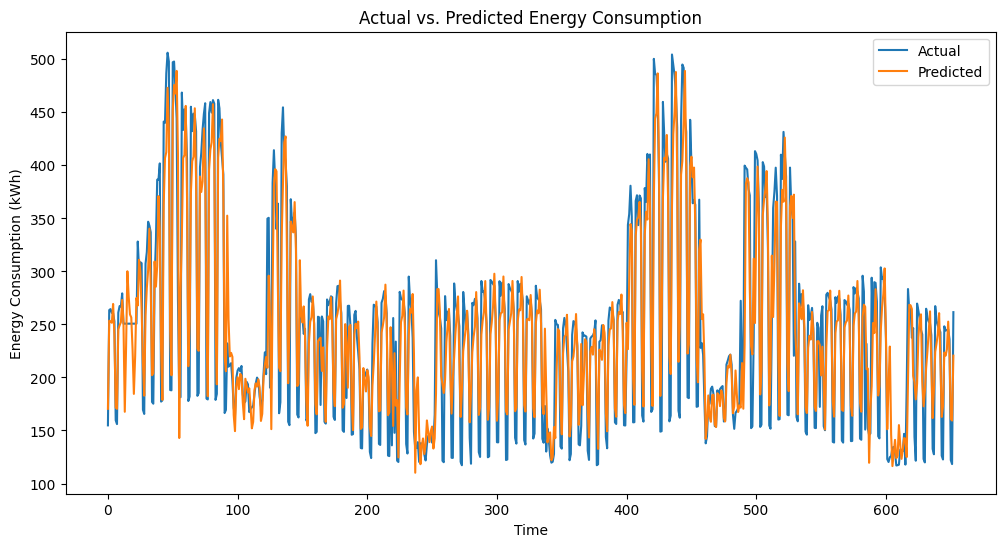

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test_inv[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.show()


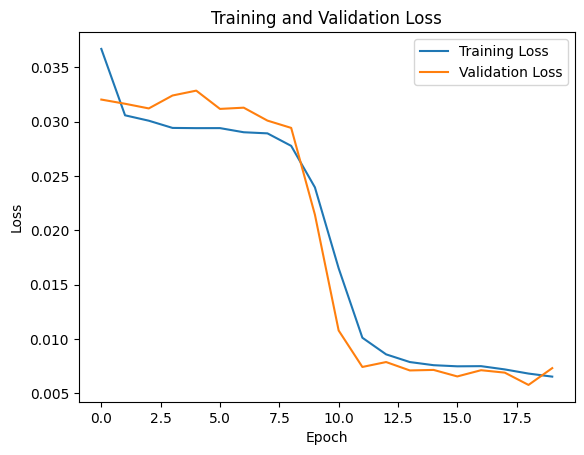

In [35]:

plt.plot(daily_history.history['loss'], label='Training Loss')
plt.plot(daily_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


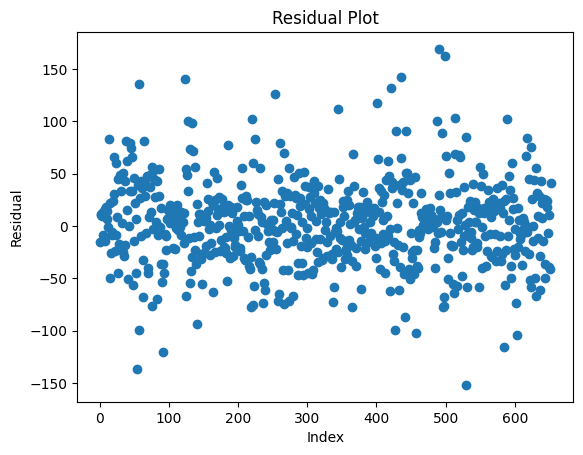

In [36]:
# Plotting the residuals (the differences between actual and predicted values) can help identify patterns or biases in your model's predictions.
residuals = Y_test_inv[0] - testPredict[:,0]
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


In [37]:
data_with_predictions = df_daily_avg.copy()

# Convert the index to datetime
daily_data_scaled.index = pd.to_datetime(daily_data_scaled.index)

# Generate timestamps for the next 7 days with daily frequency
future_dates = pd.date_range(start='2024-02-13', periods=30, freq='D')

# Reshape the data for the next 7 days
future_data = []

# Initialize the last known data as the initial input for the first prediction
last_known_data = daily_data_scaled.iloc[-look_back:].values.reshape((1, look_back, 1))

for i, future_date in enumerate(future_dates):
    # Make predictions for the next hour
    predicted_value = model.predict(last_known_data)
    
    # Inverse transform the predicted value to the original scale
    predicted_value_original_scale = scaler.inverse_transform(predicted_value)
    
    # Append the predicted value to the future_data list
    future_data.append(predicted_value_original_scale[0][0])
    
    # Update last_known_data by removing the oldest value and appending the predicted value
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# Create a DataFrame for the predicted values and timestamps
predicted_df = pd.DataFrame({'Date': future_dates, 'Q-Enginyeria-Total [kWh]': future_data})

# Append the predicted data to the original DataFrame
data_with_predictions = pd.concat([data_with_predictions, predicted_df], ignore_index=True)

# Print predicted values for each future date
for i, timestamp in enumerate(future_dates):
    print("Predicted energy consumption for", timestamp, ":", future_data[i])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

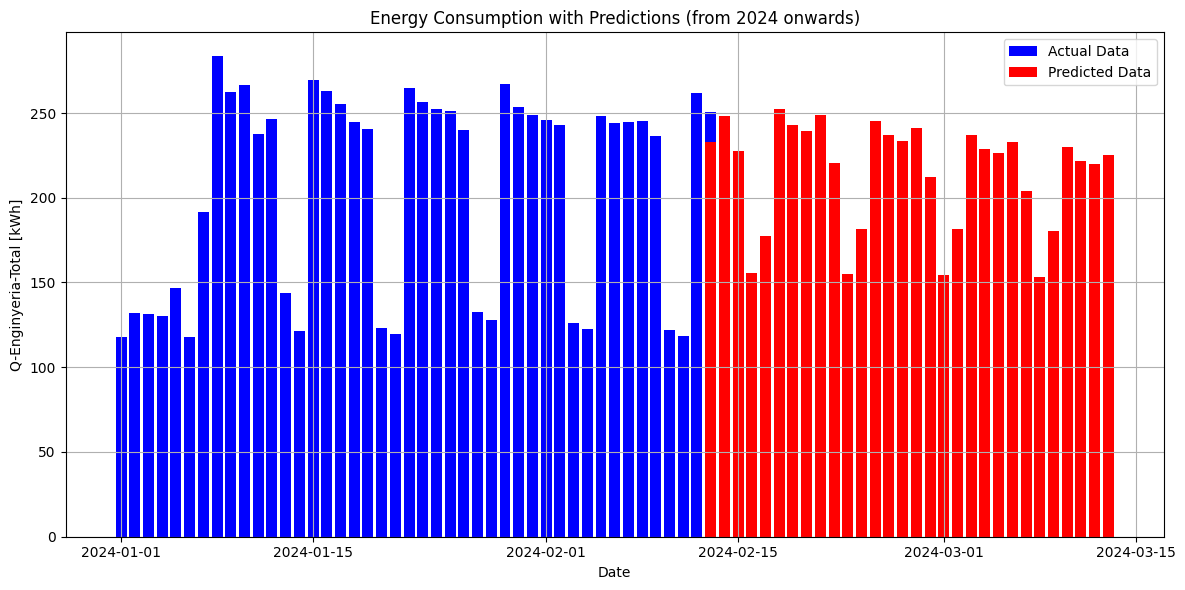

In [44]:
if not pd.api.types.is_datetime64_any_dtype(data_with_predictions['Date']):
    data_with_predictions['Date'] = pd.to_datetime(data_with_predictions['Date'])

# Filter data from the year 2024 onwards
data_with_predictions_2024_onwards = data_with_predictions[data_with_predictions['Date'].dt.year >= 2024]

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data as bar chart
plt.bar(data_with_predictions_2024_onwards['Date'], data_with_predictions_2024_onwards['Q-Enginyeria-Total [kWh]'], label='Actual Data', color='blue', width=0.8)

# Plot predicted data as scatter points
plt.bar(predicted_df['Date'], predicted_df['Q-Enginyeria-Total [kWh]'], label='Predicted Data', color='red')

plt.xlabel('Date')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.title('Energy Consumption with Predictions (from 2024 onwards)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

PREDICTIONS WITH SIX HOURLY AVERAGE


In [35]:
# Group the data by date and calculate the average energy consumption for each 6-hour interval
df_six_hourly_avg = excel_1.groupby(pd.Grouper(key='Date', freq='6H'))['Q-Enginyeria-Total [kWh]'].mean().reset_index()
df_six_hourly_avg.head()

C:\Users\Galindo\AppData\Local\Temp\ipykernel_23928\2467322935.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_six_hourly_avg = excel_1.groupby(pd.Grouper(key='Date', freq='6H'))['Q-Enginyeria-Total [kWh]'].mean().reset_index()


,Date,Q-Enginyeria-Total [kWh]
0,2018-01-01 00:00:00,178.605000
1,2018-01-01 06:00:00,198.528333
2,2018-01-01 12:00:00,197.433333
3,2018-01-01 18:00:00,187.783333
4,2018-01-02 00:00:00,164.126667


In [36]:
# Reshape the data for scaling
sixh_data_scaled = scaler.fit_transform(df_six_hourly_avg[['Q-Enginyeria-Total [kWh]']])

# Optionally convert back to DataFrame for easier handling
sixh_data_scaled = pd.DataFrame(sixh_data_scaled, index=df_six_hourly_avg.index, columns=['Q-Enginyeria-Total [kWh]'])

In [37]:
look_back = 60  # use the last 24 hours to predict the next hour
X, Y = create_dataset(sixh_data_scaled.values, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [47]:
# Define the model
model = Sequential()

# Adding the LSTM layer:
# - units: the dimensionality of the output space
# - return_sequences: True if another LSTM layer follows
# - input_shape: shape of the input. Only necessary for the first layer.
model.add(LSTM(units=30, return_sequences=True, input_shape=(None, 1)))
model.add(LSTM(units=30))
model.add(Dense(units=1))  # Output layer, 1 unit for output
model.add(Activation('relu'))  # Ensure the output is non-negative

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Galindo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

sixh_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8)

Epoch 1/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0232 - val_loss: 0.0217
Epoch 2/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0177 - val_loss: 0.0217
Epoch 3/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0173 - val_loss: 0.0199
Epoch 4/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 5/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 6/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 7/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 8/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 9/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 10/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 11/20
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 12/20
777/777 ━━━━━━━━━━━━━━━━━━━━

In [49]:
# Example of making predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transformation for original scale values
trainPredict = scaler.inverse_transform(trainPredict)
Y_train_inv = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train_inv[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(Y_test_inv[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Score: 36.85 RMSE
Test Score: 41.36 RMSE


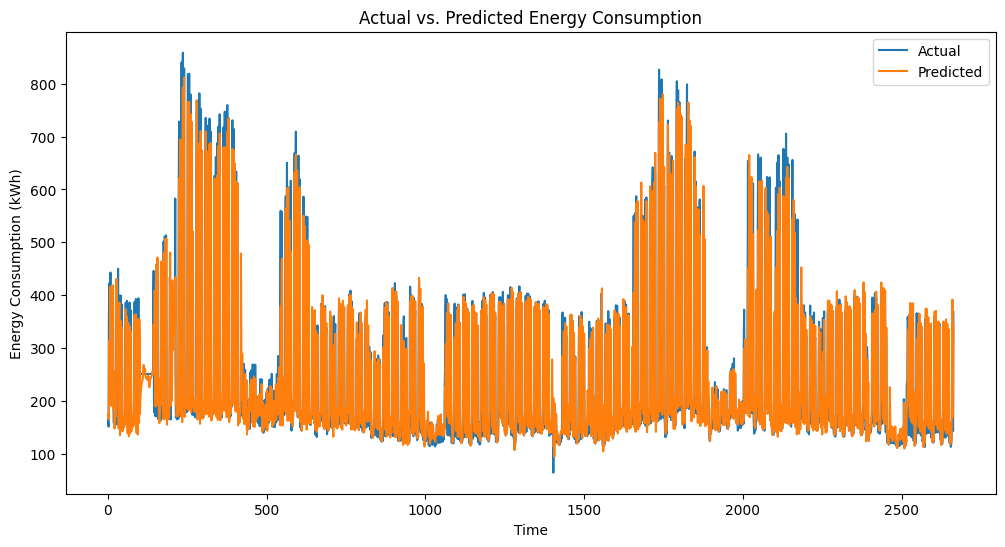

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test_inv[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.show()


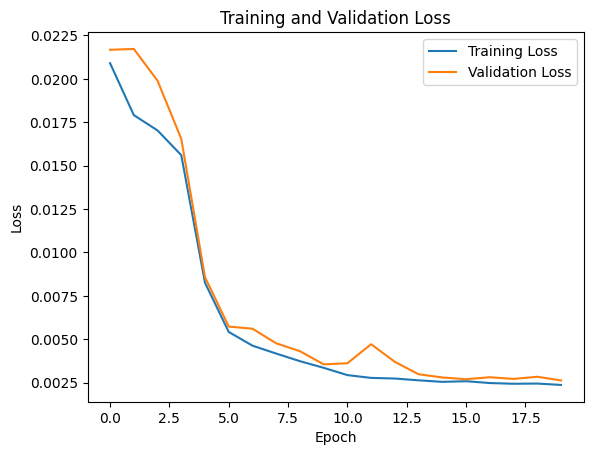

In [51]:

plt.plot(sixh_history.history['loss'], label='Training Loss')
plt.plot(sixh_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


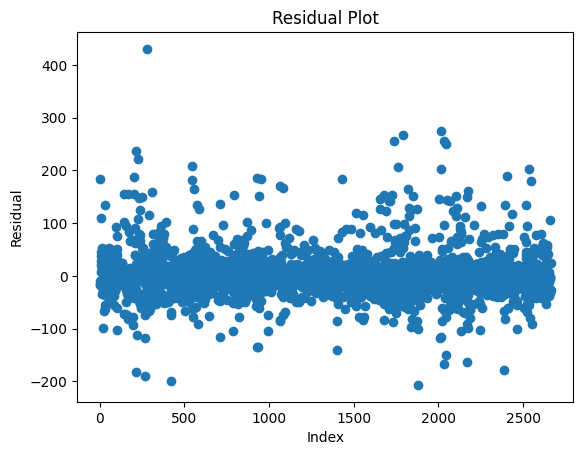

In [52]:
# Plotting the residuals (the differences between actual and predicted values) can help identify patterns or biases in your model's predictions.
residuals = Y_test_inv[0] - testPredict[:,0]
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


In [53]:
sixh_data_scaled.index = pd.to_datetime(sixh_data_scaled.index)

# Generate timestamps for the next 7 days with a frequency of every 6 hours
future_dates = pd.date_range(start='2024-02-13', periods=7*4, freq='6H')

# Reshape the data for the next 7 days
future_data = []

last_known_data = sixh_data_scaled.iloc[-look_back:].values.reshape((1, look_back, 1))

for i, future_date in enumerate(future_dates):
    # Make predictions for the next hour
    predicted_value = model.predict(last_known_data)
    
    # Inverse transform the predicted value to the original scale
    predicted_value_original_scale = scaler.inverse_transform(predicted_value)
    
    # Append the predicted value to the future_data list
    future_data.append(predicted_value_original_scale[0][0])
    
    # Update last_known_data by removing the oldest value and appending the predicted value
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# Print predicted values for each future date
for i, timestamp in enumerate(future_dates):
    print("Predicted energy consumption for", timestamp, ":", future_data[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

C:\Users\Galindo\AppData\Local\Temp\ipykernel_23928\442113385.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2024-02-13', periods=7*4, freq='6H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted energy consumption for 2024-02-13 00:00:00 : 120.076294
Predicted energy consu